## Аналитиз сервиса аренды самокатов GoFast

**Цель анализа:** Анализ общих показателей и проверка некоторых гипотез для увеличения эффективности бизнеса

**Описание:** Анализ данных проката самокатов. <br>
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
* без подписки 
    * абонентская плата отсутствует;
    * стоимость одной минуты поездки — 8 рублей;
    * стоимость старта (начала поездки) — 50 рублей;
* с подпиской Ultra 
    * абонентская плата — 199 рублей в месяц;
    * стоимость одной минуты поездки — 6 рублей;
    * стоимость старта — бесплатно.

<a name='Описание-данных'>**Описание данных** <br> </a>
Данные для анализа предоставлены в файлах и содержат информацию о пользователях, их поездках и подписках:
* `users_go.csv` - пользователи

        user_id	уникальный идентификатор пользователя
        name имя пользователя
        age	возраст
        city город
        subscription_type тип подписки (free, ultra)
        
* `rides_go.csv` - поездки

        user_id	уникальный идентификатор пользователя
        distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)
        duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
        date	дата совершения поездки

* `subscriptions_go.csv` - подписки
        
        subscription_type	тип подписки
        minute_price	стоимость одной минуты поездки по данной подписке
        start_ride_price	стоимость начала поездки
        subscription_fee	стоимость ежемесячного платежа


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
from math import factorial

### Открытие файлов с данными и вывод общей информации

In [2]:
# адреса локальных файлов
files = ['local1.csv', 'local2.csv', 'local3.csv']

# URLs на файлы
urls = [r'https://code.s3.yandex.net/***.csv', 
        r'https://code.s3.yandex.net/***.csv', 
        r'https://code.s3.yandex.net/***.csv']

try: # по возмажности локальный файл
    users, rides, subscrip = (pd.read_csv(file) for file in files)
except: # иначе URL
    users, rides, subscrip = (pd.read_csv(file) for file in urls)
    
display(users.head(3), users.tail(3))
display(rides.head(3), rides.tail(3))
display(subscrip.head(3), subscrip.tail(3))

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra


,user_id,name,age,city,subscription_type
1562,307,Ясмина,19,Краснодар,ultra
1563,47,Юрий,28,Тюмень,ultra
1564,1045,Артемий,28,Ростов-на-Дону,free


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20


,user_id,distance,duration,date
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27
18067,1534,2371.711192,15.893917,2021-12-29


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Отмечаем:
- нет данных о начале/окончании подписки, а только факт ее наличия
- некоторые user_id "не по порядку". Возможно дубликаты
- distance и duration указаны в метрах/минутах, но очень "большая точность" значений

In [3]:
# первичная проверка "не порядковых" user_id 
display(users[users.user_id == 307])
display(users[users.user_id == 47])

,user_id,name,age,city,subscription_type
306,307,Ясмина,19,Краснодар,ultra
1562,307,Ясмина,19,Краснодар,ultra


,user_id,name,age,city,subscription_type
46,47,Юрий,28,Тюмень,ultra
1563,47,Юрий,28,Тюмень,ultra


Возможная причина дублирования отмеченных пользователей связана с тем, что у обоих записей указана подписка Ultra. Вероятно, пользователь изначально был без подписки, а затем оформил её, что привело к созданию дубликата с активной подпиской у обоих "пользователей". <br>
**Проверим и обработаем такие строки в проверки на дубликаты**. 

In [4]:
# Выводим общую информацию users
display(users.info())
display(users.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


Минимальный возраст пользователя составляет 12 лет. <br>
Минимальный возраст для аренды спортивного инвентаря или транспортных средств регулируется условиями аренды компании, а также федеральными и региональными нормативными актами. <br>
Для уточнения возрастных ограничений необходима консультация юриста и представителя компании. <br>
**В рамках данного анализа возрастные данные будут использоваться в исходном виде без дополнительной проверки на корректность или обработку.** <br><br>
Дополнительно надо определить: производится аренда обычного самоката (спортивный инвентарь) или электросамокат (транспортное средства - средство индивидуальной мобильности (с 01.03.2023)).

In [5]:
# Выводим общую информацию rides
display(rides.info())
display(rides.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


* Необходимо преобразовать поле date в type: date.
* Необходимо преобразовать поле distance в type: int с математическим округлением десятичной части.
* Необходимо преобразовать поле duration в type: int с округлением в большую сторону, так как каждая дополнительная минута оплачивается согласно тарифу.
* Обнаружены аномально низкие значения в полях distance и duration. Вероятно, часть поездок была начата по ошибке и затем отменена. Необходимо установить минимальные критерии для дистанции и времени поездки, после чего удалить ошибочные записи, учитывая оплату за "начало поездки" (для аккаунтов без подписки).

In [6]:
# Выводим общую информацию subscrip
subscrip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


Пропусков в полученных данных нет. <br>
Корректное название полей.

#### Дополнительный первичный анализ полученных данных

In [7]:
# Первичное распределение с подпиской и без
raw_sub = round((users[users.subscription_type=='ultra'].shape[0] /
                               users.shape[0] * 100), 2)
print(f'В исходных данных {raw_sub} % пользователей имеют подписку')

В исходных данных 45.94 % пользователей имеют подписку


In [8]:
# Какие города предствалены с указанием кол-ва пользователей
users.city.value_counts()

city
Пятигорск         226
Екатеринбург      206
Ростов-на-Дону    202
Краснодар         196
Сочи              192
Омск              186
Тюмень            185
Москва            172
Name: count, dtype: int64

### Предобработка данных

Надо выполнить в предобработки:
1) Перевести поля date в формат date и произвести общий анализ поля
2) Перевести поля distance и duration в формат int с необходимым округлением
3) Добавить поле с указанием номера месяца поездки
4) Установить минимальные критерии для distance и duration, после чего удалить ошибочные записи, учитывая оплату за "начало поездки" (для аккаунтов без подписки). 
5) Проверить обработать дубликаты 

#### Изменение формата данных

In [9]:
# переводим поле date в формат даты
rides['date'] = pd.to_datetime(rides['date'])

# переводим поле distance в int с математическим округлением
rides['distance'] = rides['distance'].round(0).astype('int')

# переводим поле duration в int с округлением в большую сторону
rides['duration'] = np.ceil(rides['duration']).astype('int')

rides.info() # проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  int32         
 2   duration  18068 non-null  int32         
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(2), int64(1)
memory usage: 423.6 KB


In [10]:
rides.sample(5) # проверка

,user_id,distance,duration,date
5103,549,4409,20,2021-01-20
3120,336,1088,19,2021-06-07
3401,367,4223,20,2021-04-03
11794,1087,3492,24,2021-01-12
3808,410,3546,16,2021-02-23


Проведем проверку поля date

In [11]:
rides.date.describe() # проверка методом describe

count                            18068
mean     2021-06-30 19:47:21.266327296
min                2021-01-01 00:00:00
25%                2021-04-02 00:00:00
50%                2021-06-30 00:00:00
75%                2021-09-28 00:00:00
max                2021-12-30 00:00:00
Name: date, dtype: object

В предоставленных данных содержится информация за весь 2021 год. <br>
В том числе в зимний период, когда нельзя ездить на самокате на улице в большинстве городов России. **Нужно проверить эти поездки.** Возможно такие поездки осуществляются в помещениях или только в южных городах.

#### Добавляем новые поля

Поскольку данные доступны только за 2021 год, можно отображать номер месяца без указания года, так как дублирование месяцев по разным годам исключено.

In [12]:
# добавляем поле с указанием номера месяца
rides['month'] = rides['date'].dt.month

rides.sample(5) # проверка

,user_id,distance,duration,date,month
10521,993,2794,12,2021-12-19,12
7865,798,5925,22,2021-12-14,12
286,30,3254,20,2021-07-17,7
16920,1452,4676,33,2021-11-26,11
4759,512,2741,21,2021-05-31,5


#### Проверка полей distance и duration

Рассчитаем средную скорость передвижения

In [13]:
# добавляем поле с рассчетом средней скорости поездки в м/мин
rides['avg_speed'] = rides.distance / rides.duration

rides.sample(5) # проверка

,user_id,distance,duration,date,month,avg_speed
11462,1063,1596,10,2021-05-10,5,159.600000
1824,197,4226,24,2021-08-16,8,176.083333
10811,1015,4160,29,2021-07-25,7,143.448276
9171,899,723,11,2021-04-10,4,65.727273
4426,476,3167,14,2021-06-04,6,226.214286


In [14]:
rides.avg_speed.describe() # выводим данные по ср.скорости поездки

count    18068.000000
mean       197.375979
std        366.031228
min          0.090909
25%        132.076923
50%        166.181985
75%        208.560227
max       7211.000000
Name: avg_speed, dtype: float64

Медианная средняя скорость поездки составляет 166 м/мин (около 10 км/ч), при этом квартили незначительно отличаются от медианы.<br>
Средняя скорость обычного самоката на ровной дороге составляет 12–15 км/ч и сильно зависит от физических усилий и качества дорожного покрытия. <br>
На основании этого можно сделать вывод, что арендуются только обычные самокаты.

Минимальные и максимальные значения нерелевантные. Надо изучить их подробнее. 

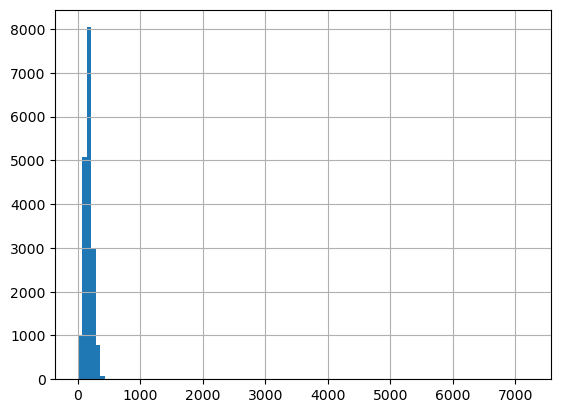

In [15]:
# выведем технический график распределения ср. скорости поездки
fig, ax = plt.subplots()

rides['avg_speed'].hist(bins=100)

# настройки графика
ax.set_title("Распределение ср. скорости поездки")
ax.set_ylabel("Количество поездок")
ax.set_xlabel("Ср. скорость, м/мин")

# включаем сетку
plt.grid(True)

plt.show();

Видим что есть значения свыше 500 м/мин. Изучим их подробнее

In [16]:
# выводим поездки с большой ср. скоростью
rides[rides['avg_speed']>=500] 

,user_id,distance,duration,date,month,avg_speed
6531,701,4196,1,2021-08-31,8,4196.0
6570,704,4831,1,2021-10-14,10,4831.0
6680,712,4684,1,2021-03-04,3,4684.0
6695,713,5216,1,2021-02-25,2,5216.0
6768,718,5197,1,2021-02-11,2,5197.0
...,...,...,...,...,...,...
17004,1460,5531,1,2021-01-19,1,5531.0
17242,1477,6725,1,2021-01-12,1,6725.0
17314,1483,4445,1,2021-03-06,3,4445.0
17505,1496,5723,1,2021-02-14,2,5723.0


95 строк с запредельной ср. скоростью поездки и временем поездки 1 мин (минимальное возможное время). <br>
Проверим кол-во поездок длительностью 1 мин

In [17]:
# получаем кол-во строк с длительностью 1 мин
rides[rides['duration']==1].shape[0]

95

In [18]:
# совмещаем два условия
rides[(rides['duration']==1) & (rides['avg_speed']>=500)].shape[0]

95

Получается все поездки длительностью 1 минуту имеют имеют большое расстояние поездки. <br>
Это может указывать либо на техническая ошибка, либо на мошенничество (т.к. оплаты взымается поминутно, а не от расстояния).

##### Проверка на мошенничество аномальных значений

Проверим гипотезу о возможном мошенничестве. <br>
Для этого создадим dataframe, содержащий информацию о пользователях с аномальными поездками, количество таких поездок, общее количество поездок, а также данные о наличии у них платной подписки.

In [19]:
# создаем df с потенциальными мошенниками и кол-вом аномальных поездок
df_fraud = rides[rides['duration']==1].user_id.value_counts() \
                .reset_index().rename(columns={'count':'cnt_anomaly'})
    
# присоединяем данные с кол-вом всех поездок данных пользователей
df_fraud = df_fraud.merge(rides.user_id.value_counts() \
                .reset_index().rename(columns={'count':'cnt_all'}),
              how='left')

# добавляем относительное значение сколько аномальных поездок от всех
df_fraud['relative_cnt'] = (df_fraud.cnt_anomaly / df_fraud.cnt_all * 100).round(2)

# добавляем данные о городе и подписки
df_fraud = df_fraud.merge(users[['user_id', 'subscription_type', 'city']],
              how='left')

df_fraud.sample(5) # проверка получившегося df

,user_id,cnt_anomaly,cnt_all,relative_cnt,subscription_type,city
75,1035,1,15,6.67,free,Сочи
34,1425,1,21,4.76,free,Сочи
47,704,1,16,6.25,free,Ростов-на-Дону
41,1374,1,21,4.76,free,Пятигорск
57,766,1,13,7.69,free,Краснодар


In [20]:
# проверяем данные по отношению аномальных ко всем
df_fraud.relative_cnt.describe() 

count    90.000000
mean      7.776000
std       2.827786
min       4.550000
25%       5.880000
50%       7.140000
75%       8.330000
max      22.220000
Name: relative_cnt, dtype: float64

Большинство поездок не попадают в аномальные

In [21]:
# проверяем по городам
df_fraud.city.value_counts()

city
Ростов-на-Дону    17
Москва            13
Пятигорск         11
Сочи              11
Омск              10
Краснодар         10
Тюмень             9
Екатеринбург       9
Name: count, dtype: int64

In [22]:
# проверяем подписки
sub = round((df_fraud[df_fraud.subscription_type=='ultra'].shape[0] /
                               df_fraud.shape[0] * 100), 2)
print(f'В df_fraud - {sub} % пользователей имеют подписку')

В df_fraud - 0.0 % пользователей имеют подписку


А вот факт что все аномальные поездки были совершены пользователями без подписки уже подозрительно т.к. примерно половина пользователей имеют подписки.

**Вывод по гипотезе о мошенничестве:** <br>
Гипотеза о мошенничестве не подтверждается, так как поездки совершались в разных городах, а относительный процент аномальных поездок невысок (не превышает 22%). Возможной причиной могут быть технические ошибки или проведение специальных мероприятий, которые позволяли пользователям пользоваться сервисом на льготных условиях. <br>
Данные об аномальных поездках рекомендуется передать в профильное подразделение компании для дальнейшего анализа.<br>
Детальная проработка аномальных данных возможна, но выходит за рамки текущего проекта.

**Удаляем из исходного df все поездки (95 шт) длительностью 1 минуту**

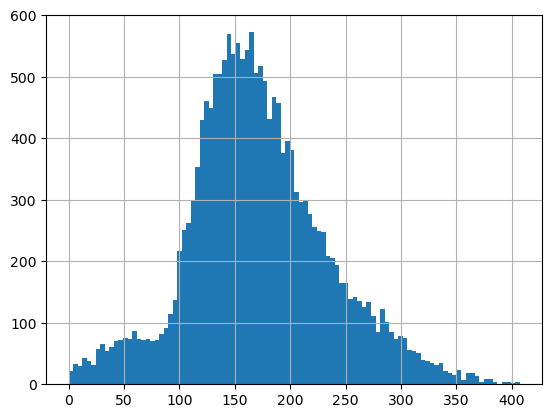

In [23]:
# удаляем аномальные поездки
rides = rides[rides['duration']>1]

# выведем технический график распределения ср. скорости поездки
fig, ax = plt.subplots()

rides['avg_speed'].hist(bins=100)

# настройки графика
ax.set_title("Распределение ср. скорости поездки")
ax.set_ylabel("Количество поездок")
ax.set_xlabel("Ср. скорость, м/мин")

# включаем сетку
plt.grid(True)

plt.show();

In [24]:
# выведем большую средную скорость и продолжительное время (15 мин)
rides[(rides['avg_speed']>350) & (rides['duration']>15)]

,user_id,distance,duration,date,month,avg_speed
7026,736,5788,16,2021-02-09,2,361.750000
7786,792,5768,16,2021-08-19,8,360.500000
7913,803,6427,17,2021-01-05,1,378.058824


Ср. скорость 378 м/мин ≈ 22,6 км/ч, что вполне возможно для определенных самокатов и физически подготовленных "водителей". <br> <br>
Согласно открытым источникам:
* Детские модели. Хорошая средняя скорость для такого самоката составляет 16–17 км/ч по ровной поверхности.
* Самокаты с колёсами 100–125 мм. Средняя скорость такого взрослого самоката колеблется в пределах 18–19 км/ч.
* Самокаты с 200-миллиметровыми колёсами. Модели с диаметром колёс 200–230 мм изначально рассчитаны на скоростное передвижение по городу. По ровной поверхности такой самокат легко идёт 22–23 км/ч (при наличии определённого опыта у водителя). <br> <br>

Для более точного анализа необходимы данные о типах самокатов, доступных для аренды.

In [25]:
# выведем данные о поездках с низкой средней скоростью
rides[(rides['avg_speed']<50)].describe()

,user_id,distance,duration,date,month,avg_speed
count,595.000000,595.000000,595.000000,595,595.000000,595.000000
mean,1058.524370,351.840336,11.507563,2021-07-02 06:53:50.924369920,6.536134,29.793486
min,1.000000,1.000000,3.000000,2021-01-01 00:00:00,1.000000,0.090909
25%,852.500000,179.000000,9.000000,2021-03-27 12:00:00,3.000000,18.878571
50%,1095.000000,332.000000,12.000000,2021-07-06 00:00:00,7.000000,31.642857
75%,1314.500000,510.500000,15.000000,2021-09-30 12:00:00,9.500000,41.733333
max,1534.000000,905.000000,19.000000,2021-12-30 00:00:00,12.000000,49.928571
std,333.100996,211.192310,3.694731,NaN,3.511399,13.567216


Большинство этих поездок имеют маленькую дистанцию при нормальном времени. Возможно, пользователи забывали "окончить поездку" или имелись технические проблемы с самокатами. <br>
Для дополнительного анализа таких поездок нужны данные по времени начала и окончания поездки и данные по обращениям в службу поддержки. <br><br>
Отдельно надо разобрать случае, где дистанция поездки аномально короткая (минимальная 1м).


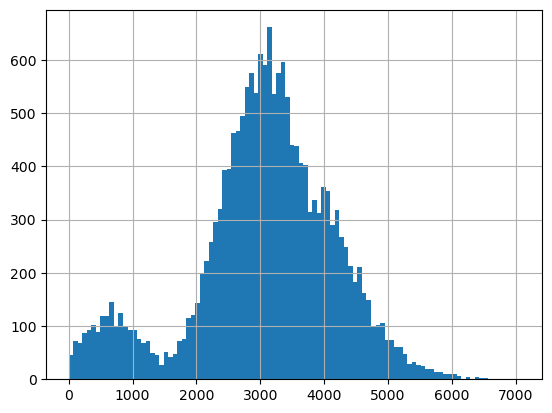

In [26]:
# выведем технический график распределения дистанции поездки

fig, ax = plt.subplots()

rides['distance'].hist(bins=100)

# настройки графика
ax.set_title("Распределение дистанции поездки")
ax.set_ylabel("Количество поездок")
ax.set_xlabel("Дистанция, м")

# включаем сетку
plt.grid(True)

plt.show();

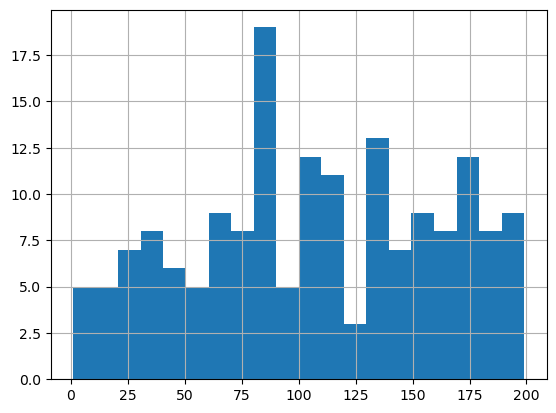

In [27]:
# проверим распределение на дистанции менее 200м
# выведем технический график распределения дистанции поездки
fig, ax = plt.subplots()

rides[(rides['distance']<200)]['distance'].hist(bins=20)

# настройки графика
ax.set_title("Распределение дистанции поездки")
ax.set_ylabel("Количество поездок")
ax.set_xlabel("Дистанция, м")

# включаем сетку
plt.grid(True)

plt.show();

Видим пик дистанций около 80м.

In [28]:
# выведем поездки менее 100м
rides[(rides['distance']<100)]

,user_id,distance,duration,date,month,avg_speed
6611,707,29,15,2021-09-12,9,1.933333
6691,712,24,3,2021-11-22,11,8.000000
6816,721,63,8,2021-09-25,9,7.875000
6850,724,30,4,2021-05-09,5,7.500000
7367,760,55,9,2021-10-13,10,6.111111
...,...,...,...,...,...,...
17414,1489,22,7,2021-10-06,10,3.142857
17502,1495,79,10,2021-05-16,5,7.900000
17646,1506,37,5,2021-06-27,6,7.400000
17722,1511,87,4,2021-01-21,1,21.750000


Поездки до 100м часто имеют нормальное время. Скорее всего имело место ошибка или техническая проблема. **Удалим все поездки менее 100м (77 строк).**

In [29]:
# удаляем все поездки с дистанцией менее 100м
rides = rides[(rides['distance']>=100)]

rides.describe()

,user_id,distance,duration,date,month,avg_speed
count,17896.000000,17896.000000,17896.000000,17896,17896.000000,17896.000000
mean,840.283192,3072.783751,18.438143,2021-06-30 17:35:56.459543808,6.484075,172.093703
min,1.000000,100.000000,3.000000,2021-01-01 00:00:00,1.000000,7.600000
25%,483.000000,2547.000000,14.000000,2021-04-02 00:00:00,4.000000,132.412197
50%,885.000000,3133.000000,18.000000,2021-06-29 00:00:00,6.000000,166.090909
75%,1212.000000,3767.000000,22.000000,2021-09-28 00:00:00,9.000000,207.901190
max,1534.000000,7066.000000,41.000000,2021-12-30 00:00:00,12.000000,407.416667
std,435.392427,1093.521011,5.951098,NaN,3.436044,62.539708


**Вывод по подразделу:**
* Удалили из исходного df все поездки (95 шт) длительностью 1 минуту (как явно нерелевантные)
* Удалили из исходного df все поездки (77 шт) дальностью менее 100 метров (как явно нерелевантные)
* Выявили аномальные поездки для передачи их в профильное подразделение компании для дальнейшего анализа.<br>
<br><br>

Подробнее определить генеральную выборку можем в разделе аналитики данных

#### Проверка месяца аренды самокатов

Нам предоставлены данные аренды самокатов разных городов, в том числе и южных. Проверим распределение поездок в зимние месяцы по городам. <br><br>
Из открытых источников:
* Сезон проката самокатов в Москве с апреля по октябрь включительно.
* Сезон проката самокатов в Сочи круглогодичный.

In [30]:
# выведем общее кол-во поездок в зимние месяцы
rides[(rides['month']<3) | (rides['month']>11)].shape[0]

4405

In [31]:
# распределение аренды в зимние время
rides[(rides['month']<3) | (rides['month']>11)].merge(
    users[['user_id', 'city']], how='left')['city'].value_counts()

city
Пятигорск         645
Екатеринбург      621
Ростов-на-Дону    613
Краснодар         562
Сочи              547
Тюмень            529
Москва            484
Омск              478
Name: count, dtype: int64

У нас отсутствуют данные о городе, где происходила аренда, и есть только информация о городе регистрации аккаунта. <br><br>

Поездки в зимние месяцы равномерно распределены между городами регистрации пользователей. Такая картина маловероятно связана с естественной миграцией, что указывает на необходимость дополнительного анализа. <br><br>

**Для принятия обоснованных решений по поездкам вне сезона требуются дополнительные данные:**
* Место аренды самоката.
* Сезонность аренды по городам.
* Информация о возможных мероприятиях (например, аренда в закрытых помещениях).
* Методология сбора данных о пользователях.
<br><br>
Эти данные помогут лучше понять причины аномалий и принять взвешенные решения.

#### Проверка на дубликаты

Ранее мы уже обнаружили дубликаты в пользователях. Поэтому сначало проверим дубликаты в данных по поездкам, а потом обработаем дубликаты в пользователей.

##### Проверка дубликатов в rides

In [32]:
# проверка на явные дубликаты
rides[rides[['user_id', 'date', 'distance']].duplicated(keep=False)]

,user_id,distance,duration,date,month,avg_speed


Явных дубликатов нет. <br>
Дополнительно проверим поездки в один день, где одна поездка меньше 5 минут.

In [33]:
# создаем временный df с дубликатами по user_id и date
temp = rides[rides[['user_id', 'date']].duplicated(keep=False
                                        )].sort_values(['user_id', 'date'])

# выводим данные по поездкам-дубликатам, 
# где хотя бы одна поездка, для пользователя, в день была менее 5 минут
# используем конструкцию установки индексов и вхождение индексов,
# чтобы исключить дни, когда все поездки пользователя были более 5 минут
temp[temp.set_index(['user_id', 'date']).index.isin(
    temp[temp.duration<5].set_index(['user_id', 'date']).index)]

,user_id,distance,duration,date,month,avg_speed
7314,757,2738,12,2021-10-06,10,228.166667
7315,757,430,4,2021-10-06,10,107.500000
11758,1084,1988,11,2021-06-18,6,180.727273
11759,1084,296,4,2021-06-18,6,74.000000
13047,1179,1489,7,2021-03-27,3,212.714286
13048,1179,397,4,2021-03-27,3,99.250000
13537,1213,3304,21,2021-04-11,4,157.333333
13538,1213,128,3,2021-04-11,4,42.666667
15511,1356,5148,20,2021-02-24,2,257.400000
15512,1356,181,3,2021-02-24,2,60.333333


Количество поездок-"дубликатов" невелико, поэтому их можно оставить без изменений. <br><br>
Возможно, такие случаи связаны с проблемами при аренде самоката. Для проверки этой гипотезы необходимы дополнительные данные:
* Время начала и завершения аренды.
* Информация об обращениях в техническую поддержку сервиса.

##### Проверка дубликатов в users

О наличии дубликатов в users по user_id нам уже известно. Проверим различные варианты дубликатов по другим полям.

In [34]:
# все ли дубликаты по user_id являются полными
cnt_id_dup = users[users.duplicated('user_id', keep=False)].shape[0]
cnt_full_dup = users[users.duplicated(keep=False)].shape[0]
flag_full_dup = cnt_id_dup == cnt_full_dup

if flag_full_dup:
    print(f'Все дубликаты ({cnt_full_dup} строки) являются полными')
else:
    print(f'Не все дубликаты по user_id ({cnt_id_dup}) являются полными ({cnt_full_dup})')

Все дубликаты (62 строки) являются полными


In [35]:
# какие виды подписок и количество есть в дубликатах пользователей
users[users.duplicated(keep=False)]['subscription_type'].value_counts()

subscription_type
ultra    40
free     22
Name: count, dtype: int64

В данных дубликатов пользователей встречаются разные типы подписок (как платные, так и бесплатные). При этом за каждым пользователем закреплена конкретная подписка, которая, согласно данным, не изменяется. Гипотеза о том, что дубликаты возникают из-за смены подписки, маловероятна, так как количество дубликатов незначительно (62 дубликата, 31 пользователь), а процесс изменения подписки, скорее всего, более динамичный.
<br><br>
Отдельно возникает вопрос о том, как учитывается подписка в периоды, когда аренда не активна. Для детального анализа необходимы дополнительные данные:
* Даты начала и окончания подписок.
* Регламент оплаты подписок (минимальные сроки, условия).
* Учет времени вне сезона аренды.
<br><br>

**На основании текущих данных примем решение удалить все дубликаты пользователей.**

In [36]:
# удаляем дубликаты пользователей
users = users.drop_duplicates()

users[users.duplicated()] # проверка

,user_id,name,age,city,subscription_type


**Вывод по предобработке данных:**
- Данные предоставлены за весь 2021 год
- Перевели поле date в формат date
- Перевели поле distance в формат int c математическим округлением
- Перевели поле duration в формат int c округлением в большую сторону
- Добавили в df rides поле month с указанием номера месяца поездки
- Добавили в df rides поле avg_speed с указанием средней скорости поездки
- Определили что производится аренда обычных самокатов
- [Выполнили проверку на мошенничество аномальных поездок](#Проверка-на-мошенничество-аномальных-значений)
- Из df rides удалили 95 строк со временем поездки 1 мин, 77 строк с дальностью поездки менее 100 м
- Выявили невозможность по текущим данным проверить дату/месяц поездки
- Из df users удалили 31 строку с дубликатами пользователей
<br><br>

**Для увеличения качества анализа требуется дополнительные данные:**

* Типы арендуемых самокатов
* Место аренды самоката
* Сезонность аренды по городам
* Время начала и завершения аренды
* Даты начала и окончания подписок
* Информация об обращениях в техническую поддержку сервиса
* Информация о возможных мероприятиях (например, аренда в закрытых помещениях, маркетинговые мероприятия и прочее)
* Методология сбора данных о пользователях
* Регламент оплаты подписок (минимальные сроки, условия)
* Учет времени вне сезона аренды


### Объединение данных в один DataFrame

In [37]:
# объеденить данные в один dataframe

# объединяем rides и users
df = rides.merge(users , how='left', on='user_id')

# добавляем данные по подписки
df = df.merge(subscrip, how='left', on='subscription_type')

df.shape[0] == rides.shape[0] # проверка по кол-ву строк

True

In [ ]:
# проверка на пропуски
miss_count = df.isna().sum().sum() # суммарное кол-во попусков в df

if miss_count == 0:
    print('Пропусков не обнаружено')
else:
    print(f'Суммарное количество пропусков = {miss_count}')

In [38]:
df.sample(5) # проверка результата объединения

,user_id,distance,duration,date,month,avg_speed,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
707,77,3998,24,2021-07-30,7,166.583333,Анна,23,Пятигорск,ultra,6,0,199
1396,151,4524,25,2021-10-11,10,180.960000,Майя,26,Омск,ultra,6,0,199
9995,961,1950,15,2021-10-16,10,130.000000,Захар,20,Тюмень,free,8,50,0
14266,1271,304,8,2021-01-31,1,38.000000,Евгений,33,Краснодар,free,8,50,0
4973,536,3159,20,2021-01-01,1,157.950000,Ростислав,25,Ростов-на-Дону,ultra,6,0,199


Для удобства фильтрации данных по пользователям с платной подпиской и без нее, создадим логические маски

In [39]:
# создаем логические маски
flag_ultra = (df.subscription_type=='ultra') # для выбора данных с платной подпиской
flag_free = (df.subscription_type=='free') # для выбора данных с бесплатной подпиской

### Исследовательский анализ данных

#### Распределение пользователей по городам

In [40]:
# составим таблицу с распределением пользователей по городам
users_city = users['city'].value_counts().reset_index()
users_city.columns = ['city', 'cnt']

# добавим данные по относительным значениям
users_city['rel_cnt'] = (users_city.cnt / users_city.cnt.sum() *100).round(2)

users_city

,city,cnt,rel_cnt
0,Пятигорск,219,14.28
1,Екатеринбург,204,13.30
2,Ростов-на-Дону,198,12.91
3,Краснодар,193,12.58
4,Сочи,189,12.32
5,Омск,183,11.93
6,Тюмень,180,11.73
7,Москва,168,10.95


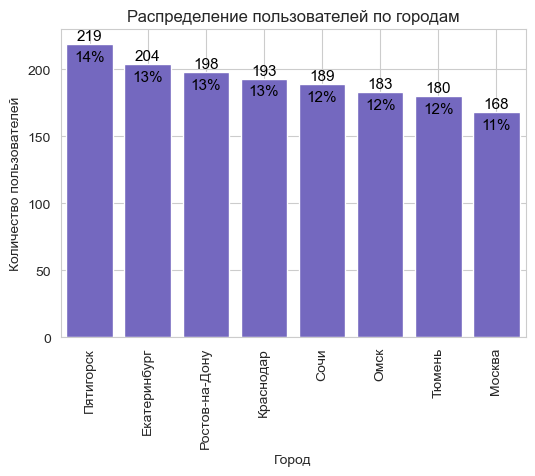

In [41]:
# выведем распределение пользователей по городам
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# создаем график
sns.barplot(data=users_city, x='city', y='cnt', color='#6A5ACD')

# настройки графика
ax.set_title("Распределение пользователей по городам")
ax.set_ylabel("Количество пользователей")
ax.set_xlabel("Город")
fig.set_figheight(4)
fig.set_figwidth(6)

# добавление меток (с указанием значений над каждым столбцом и процентом)
for p in ax.patches:
    abs_value = int(p.get_height()) # абсолютное значение высоты столбца
    # относительное значение
    rel_value = int((p.get_height() / users_city.cnt.sum() *100).round(0))
    
    ax.annotate(abs_value, # абсолютное значения
        (p.get_x() + p.get_width() / 2, p.get_height()), # позиционирование по x,y
        ha='center', va='baseline', fontsize=11, color='black',
        xytext=(0, 3), textcoords='offset points')
    
    ax.annotate(f'{rel_value}%', # относительное значения
        (p.get_x() + p.get_width() / 2, p.get_height()), # позиционирование по x,y
        ha='center', va='baseline', fontsize=11, color='black',
        xytext=(0, -12), textcoords='offset points')

# поворачиваем метки x
plt.xticks(rotation=90)
# включаем сетку
plt.grid(True)

plt.show()

Распределение пользователей по городам является достаточно равномерным: максимальная разница между городами составляет не более 3%.

#### Соотношение пользователей с платными подписками и без

In [42]:
# Общее распределение с платной подпиской и без
raw_sub = round((users[users.subscription_type=='ultra'].shape[0] /
                               users.shape[0] * 100), 2)
print(f'{raw_sub} % пользователей имеют платную подписку')

45.57 % пользователей имеют платную подписку


In [43]:
sub_city = users.pivot_table(index='city', values='user_id', columns='subscription_type',
                 aggfunc={'user_id':'count'}, margins=True
                 ).drop('All', axis=0).sort_values('All', ascending=False)

sub_city

subscription_type,free,ultra,All
city,,,
Пятигорск,125,94,219
Екатеринбург,112,92,204
Ростов-на-Дону,109,89,198
Краснодар,112,81,193
Сочи,103,86,189
Омск,92,91,183
Тюмень,98,82,180
Москва,84,84,168


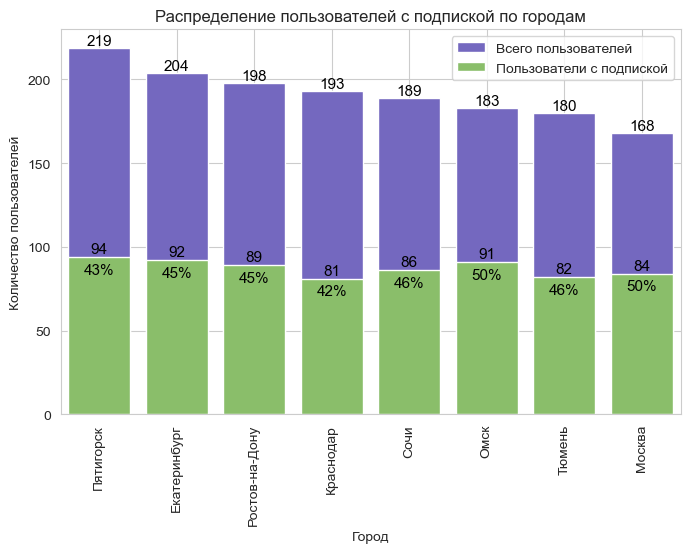

In [44]:
# выведем распределение пользователей по городам с учетом подписки по городам
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# строим график по всем пользователям
sns.barplot(data=sub_city.reset_index(), x='city', y='All', 
            color='#6A5ACD', label='Всего пользователей')

# строим график по пользователям с платной подпиской
sns.barplot(data=sub_city.reset_index(), x='city', y='ultra',
            color='#87CC5C', label='Пользователи с подпиской')

# настройки графика
ax.set_title("Распределение пользователей с подпиской по городам")
ax.set_ylabel("Количество пользователей")
ax.set_xlabel("Город")
fig.set_figheight(5)
fig.set_figwidth(8)

# Добавление меток (с указанием значений каждого столбца)
main_count = list() # Создаем список для записи значений 'основного' столбца
for number_bar, bars in enumerate(ax.containers): # Проходимся по столбцам
    i = 0 # Порядковый номер 'основного' столбца на графике
    for p in bars: # Получаем геометрические данные по столбцам
        count_in_cat = int(p.get_height()) # Записываем в переменну количественное значение 
        if number_bar == 0: # Если первый столбец (основной, всего)
                main_count.append(count_in_cat)
                i+=1
                ax.annotate(count_in_cat, (p.get_x() + p.get_width()/2, p.get_height()), 
                            ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 2), 
                            textcoords='offset points')
        else: # Для других 'подстолбцов'
            percent = count_in_cat/main_count[i]*100
            i+=1
            ax.annotate(count_in_cat, (p.get_x() + p.get_width()/2, p.get_height()), 
                        ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 3), 
                        textcoords='offset points')
            ax.annotate(f'{percent:.0f}%', (p.get_x() + p.get_width()/2, p.get_height()), 
                ha='center', va='baseline', fontsize=11, color='black', xytext=(0, -12), 
                textcoords='offset points')   

# поворачиваем метки x
plt.xticks(rotation=90)
# включаем сетку
plt.grid(True)

plt.show()

Среднее соотношение между пользователями с платной подпиской и без нее составляет 45,6%. <br> Распределение пользователей с подпиской по городам достаточно равномерное, однако в Москве и Омске наблюдается небольшое превышение доли таких пользователей — по 50%.

#### Распределение пользователей по возрасту

Ранее уже определили минимальный и максимальный возраст от 12 до 43 лет. <br>
Выведем основные параметры распределения по возрасту.

In [45]:
# выведем основные параметры распределения  по возрасту
print(f'Максимальный возраст пользователя: {users.age.max()} лет')
print(f'Минимальный возраст пользователя: {users.age.min()} лет')
print(f'Средний возраст пользователя: {(users.age.mean()).round(2)} лет')
print(f'Медианный возраст пользователя: {users.age.median()} лет')

Максимальный возраст пользователя: 43 лет
Минимальный возраст пользователя: 12 лет
Средний возраст пользователя: 24.9 лет
Медианный возраст пользователя: 25.0 лет


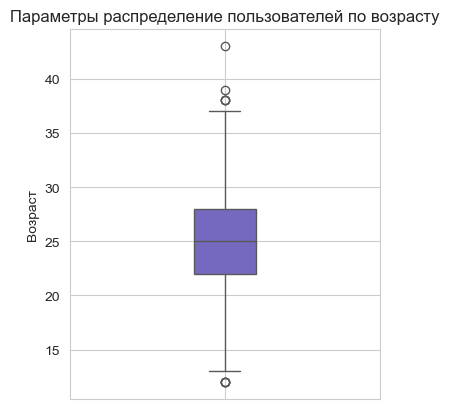

In [46]:
# визуальный анализ параметров распределение по возрасту
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# строим график по всем пользователям
sns.boxplot(data=users, y='age', width=0.2, color='#6A5ACD')

# настройки графика
ax.set_title("Параметры распределение пользователей по возрасту")
ax.set_ylabel("Возраст")
fig.set_figwidth(4)

# включаем сетку
plt.grid(True)

plt.show()

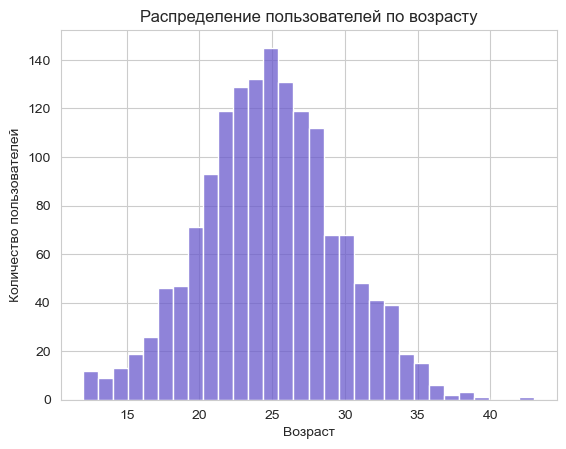

In [47]:
# выведем распределение пользователей по возрасту
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# строим график по всем пользователям
sns.histplot(data=users, x='age', color='#6A5ACD')

# настройки графика
ax.set_title("Распределение пользователей по возрасту")
ax.set_ylabel("Количество пользователей")
ax.set_xlabel("Возраст")

# включаем сетку
plt.grid(True)

plt.show()

In [48]:
# разделим пользователей на возрастные группы

# определяем границы биннов
bins = [12, 18, 21, 24, 27, 30, float('inf')]  # float('inf') для верхней границы
# определяем метки для групп
labels = ['12-17', '18-20', '21-23', '24-26', '27-29', '30+']

# создаем новый столбец с возрастными группами
df['group_age'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

df[['user_id', 'age', 'group_age']].sample(5) # проверка

,user_id,age,group_age
14040,1255,21,21-23
10282,981,17,12-17
2653,282,33,30+
7670,785,28,27-29
6480,697,24,24-26


In [49]:
# создадим таблицу с расспределением по возрасту и платной подписке
sub_age = df.pivot_table(index='group_age', values='user_id', 
                columns='subscription_type', observed=False,
                 aggfunc={'user_id':'count'}, margins=True
                 ).drop('All', axis=0)

sub_age

subscription_type,free,ultra,All
group_age,,,
12-17,556,416,972
18-20,1083,758,1841
21-23,2732,1276,4008
24-26,3144,1698,4842
27-29,2245,1183,3428
30+,1636,1169,2805


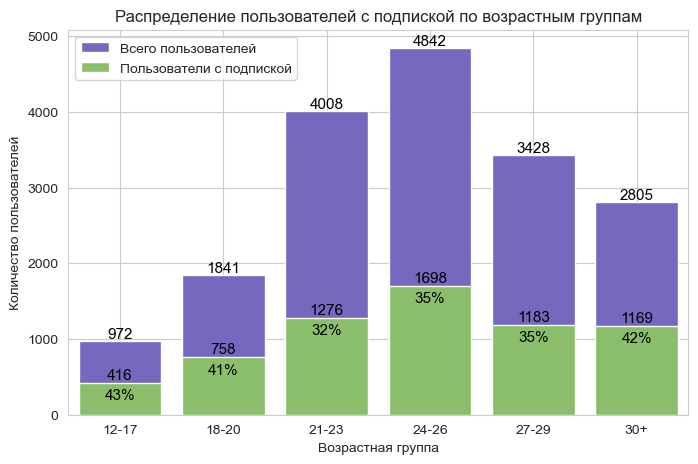

In [50]:
# выведем распределение пользователей по возрастным группам
# с учетом платной подписки 
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# строим график по всем пользователям
sns.barplot(data=sub_age.reset_index(), x='group_age', y='All', 
            color='#6A5ACD', label='Всего пользователей')

# строим график по пользователям с платной подпиской
sns.barplot(data=sub_age.reset_index(), x='group_age', y='ultra',
            color='#87CC5C', label='Пользователи с подпиской')

# настройки графика
ax.set_title("Распределение пользователей с подпиской по возрастным группам")
ax.set_ylabel("Количество пользователей")
ax.set_xlabel("Возрастная группа")
fig.set_figheight(5)
fig.set_figwidth(8)

# Добавление меток (с указанием значений каждого столбца)
main_count = list() # Создаем список для записи значений 'основного' столбца
for number_bar, bars in enumerate(ax.containers): # Проходимся по столбцам
    i = 0 # Порядковый номер 'основного' столбца на графике
    for p in bars: # Получаем геометрические данные по столбцам
        count_in_cat = int(p.get_height()) # Записываем в переменну количественное значение 
        if number_bar == 0: # Если первый столбец (основной, всего)
                main_count.append(count_in_cat)
                i+=1
                ax.annotate(count_in_cat, (p.get_x() + p.get_width()/2, p.get_height()), 
                            ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 2), 
                            textcoords='offset points')
        else: # Для других 'подстолбцов'
            percent = count_in_cat/main_count[i]*100
            i+=1
            ax.annotate(count_in_cat, (p.get_x() + p.get_width()/2, p.get_height()), 
                        ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 3), 
                        textcoords='offset points')
            ax.annotate(f'{percent:.0f}%', (p.get_x() + p.get_width()/2, p.get_height()), 
                ha='center', va='baseline', fontsize=11, color='black', xytext=(0, -12), 
                textcoords='offset points')   
            
plt.legend() # включаем легенду
# включаем сетку
plt.grid(True)

plt.show()

- Максимальный возраст пользователя: 43 лет
- Минимальный возраст пользователя: 12 лет
- Средний возраст пользователя: 24.9 лет
- Медианный возраст пользователя: 25 лет
- Общее распределение по возрасту: нормальное с вершиной в 25 лет
- Доля платной подписки распределена относительно равномерно среди всех возрастных групп, составляя от 42% до 52%

#### Распределение дальности поездки

In [51]:
# выведем основные параметры поездок по дальности
print(f'Максимальная дальность поездки: {rides.distance.max()} м')
print(f'Минимальная дальность поездки: {rides.distance.min()} м')
print(f'Средняя дальность поездки: {(rides.distance.mean()).round(2)} м')
print(f'Медианная дальность поездки: {rides.distance.median()} м')

Максимальная дальность поездки: 7066 м
Минимальная дальность поездки: 100 м
Средняя дальность поездки: 3072.78 м
Медианная дальность поездки: 3133.0 м


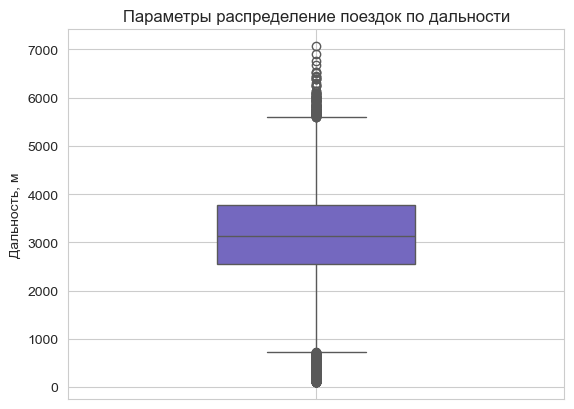

In [52]:
# визуальный анализ параметров распределение по дальности
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# строим график по всем поездкам
sns.boxplot(data=rides, y='distance', width=0.4, color='#6A5ACD')

# настройки графика
ax.set_title("Параметры распределение поездок по дальности")
ax.set_ylabel("Дальность, м")


# включаем сетку
plt.grid(True)

plt.show()

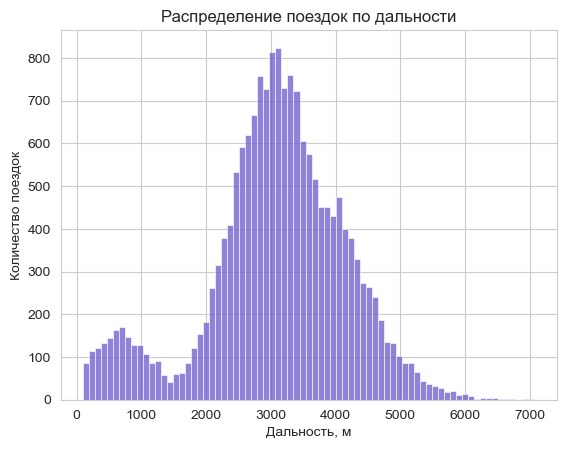

In [53]:
# выведем распределение дальности поездок
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# строим график по всем поездкам
sns.histplot(data=rides, x='distance', color='#6A5ACD')

# настройки графика
ax.set_title("Распределение поездок по дальности")
ax.set_ylabel("Количество поездок")
ax.set_xlabel("Дальность, м")

# включаем сетку
plt.grid(True)

plt.show()

- Максимальная дальность поездки: 7066 м
- Минимальная дальность поездки: 100 м
- Средняя дальность поездки: 3072.78 м
- Медианная дальность поездки: 3133.0 м
- Общее распределение поездок по дальности: нормальное с вершиной в 3200 метров. Наблюдается небольшой рост числа поездок на расстояние около 700 метров. Поездки короче 100 метров были [исключены из анализа](#Проверка-полей-distance-и-duration).
<br><br>

Анализ дальности поездки для пользователей с платной подпиской и без нее выполним в следующем подразделе.

#### Распределение длительности поездки

In [54]:
# выведем основные параметры поездки по длительности
print(f'Максимальная длительность поездки: {rides.duration.max()} мин')
print(f'Минимальная длительность поездки: {rides.duration.min()} мин')
print(f'Средняя длительность поездки: {(rides.duration.mean()).round(2)} мин')
print(f'Медианная длительность поездки: {rides.duration.median()} мин')

Максимальная длительность поездки: 41 мин
Минимальная длительность поездки: 3 мин
Средняя длительность поездки: 18.44 мин
Медианная длительность поездки: 18.0 мин


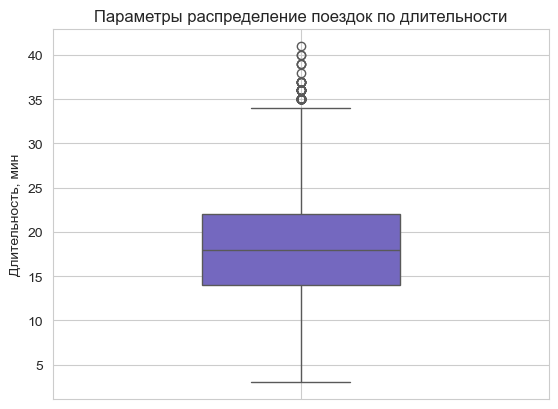

In [55]:
# визуальный анализ параметров распределение по длительности
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# строим график по всем поездкам
sns.boxplot(data=rides, y='duration', width=0.4, color='#6A5ACD')

# настройки графика
ax.set_title("Параметры распределение поездок по длительности")
ax.set_ylabel("Длительность, мин")

# включаем сетку
plt.grid(True)

plt.show()

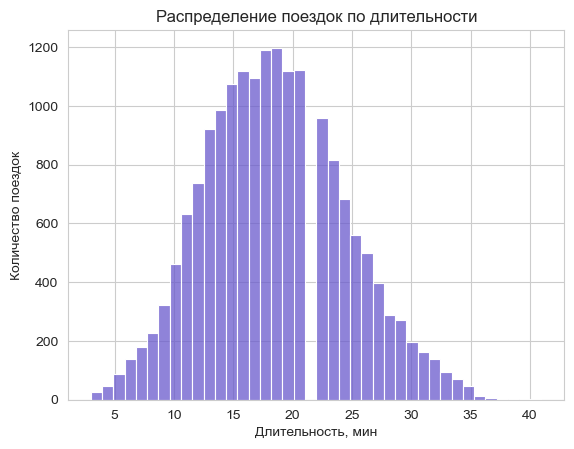

In [56]:
# выведем распределение длительности поездок
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# строим график по всем поездкам
sns.histplot(data=rides, x='duration', color='#6A5ACD', bins=40)

# настройки графика
ax.set_title("Распределение поездок по длительности")
ax.set_ylabel("Количество поездок")
ax.set_xlabel("Длительность, мин")

# включаем сетку
plt.grid(True)

plt.show()

- Максимальная длительность поездки: 41 мин
- Минимальная длительность поездки: 3 мин
- Средняя длительность поездки: 18.44 мин
- Медианная длительность поездки: 18.0 мин
- Общее распределение поездок по дальности: нормальное с вершиной в 18 минут. Поездки меньше 1 минуты были [исключены из анализа](#Проверка-полей-distance-и-duration).
<br><br>

Анализ длительности поездки для пользователей с платной подпиской и без нее выполним в следующем подразделе.

#### Распределение дальности поездки с учетом подписки

<a name=param_dist> Отобразим общие параметры по дальности поездки с учетом подписки </a>

In [57]:
param = 'distance' # указываем по какому параметру собираем данные
text_param = 'дальность' # название параметра для вставки в текст

# собираем данные с параметрами
data_temp = {
    'Параметр': [f'Максимальная {text_param} поездки:',
                 f'Минимальная {text_param} поездки:',
                 f'Средняя {text_param} поездки:',
                f'Медианная {text_param} поездки:',
                'Количество поездок:'],
    'free': [df[flag_free][param].max(), 
             df[flag_free][param].min(),
             (df[flag_free][param].mean()).round(2),
             df[flag_free][param].median(),
             df[flag_free].shape[0]],
    'ultra': [df[flag_ultra][param].max(), 
              df[flag_ultra][param].min(),
             (df[flag_ultra][param].mean()).round(2),
             df[flag_ultra][param].median(),
             df[flag_ultra].shape[0]]
        }

df_par_dist = pd.DataFrame(data_temp) # создаем dataframe

df_par_dist # выводим результат

,Параметр,free,ultra
0,Максимальная дальность поездки:,7066.00,5700.00
1,Минимальная дальность поездки:,100.00,244.00
2,Средняя дальность поездки:,3048.45,3115.44
3,Медианная дальность поездки:,3111.50,3149.00
4,Количество поездок:,11396.00,6500.00


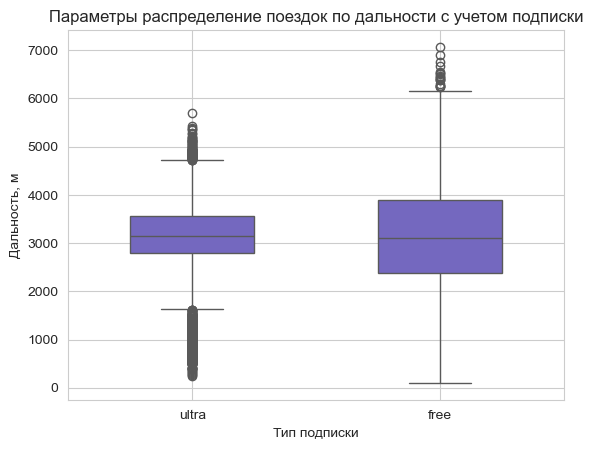

In [58]:
 # визуальный анализ параметров распределение по дальности с учетом подписки
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# строим график по всем поездкам
sns.boxplot(data=df, x='subscription_type', y='distance',
            width=0.5, color='#6A5ACD')

# настройки графика
ax.set_title("Параметры распределение поездок по дальности с учетом подписки")
ax.set_xlabel("Тип подписки")
ax.set_ylabel("Дальность, м")

# включаем сетку
plt.grid(True)

plt.show()

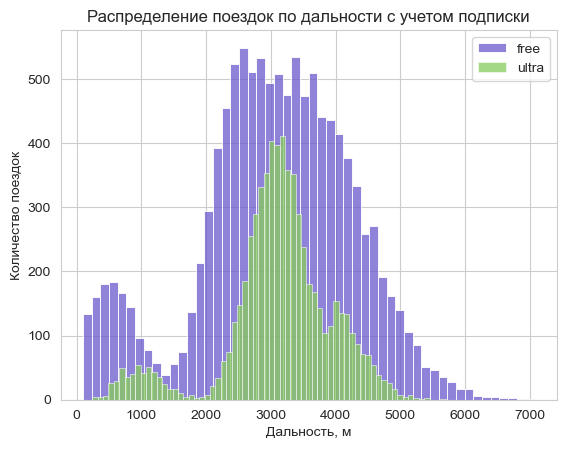

In [59]:
# выведем распределение дальности поездок с учетом типа подписки
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# строим график с free подпиской
sns.histplot(data=df[flag_free], x='distance', color='#6A5ACD',
             label='free')
# строим график с ultra подпиской
sns.histplot(data=df[flag_ultra], x='distance', color='#87CC5C',
             label='ultra')

# настройки графика
ax.set_title("Распределение поездок по дальности c учетом подписки")
ax.set_ylabel("Количество поездок")
ax.set_xlabel("Дальность, м")

# включаем легенду
plt.legend()
# включаем сетку
plt.grid(True)

plt.show()

- [Сравнительная таблица параметров распределения по дальности поездки с учетом подписки](#param_dist)
- Диапазон дальности поездок у пользователей с подпиской ultra более сконцентрирован по сравнению с пользователями без подписки.
- Основной пик дальности для пользователей с подпиской ultra находится на отметке 3000 метров, тогда как у пользователей без подписки он распределен в диапазоне от 2200 до 4000 метров.
- Для коротких поездок пик у пользователей с подпиской ultra наблюдается около 1000 метров, а у пользователей без подписки — около 500 метров.

#### Распределение длительности поездки с учетом подписки

<a name=param_dur> Отобразим общие параметры по длительности поездки с учетом подписки </a>

In [60]:
param='duration' # указываем по какому параметру собираем данные
text_param = 'длительность' # название параметра для вставки в текст

# собираем данные с параметрами
data_temp = {
    'Параметр': [f'Максимальная {text_param} поездки:',
                 f'Минимальная {text_param} поездки:',
                 f'Средняя {text_param} поездки:',
                f'Медианная {text_param} поездки:',
                'Количество поездок:'],
    'free': [df[flag_free][param].max(), 
             df[flag_free][param].min(),
             (df[flag_free][param].mean()).round(2),
             df[flag_free][param].median(),
             df[flag_free].shape[0]],
    'ultra': [df[flag_ultra][param].max(), 
              df[flag_ultra][param].min(),
             (df[flag_ultra][param].mean()).round(2),
             df[flag_ultra][param].median(),
             df[flag_ultra].shape[0]]
        }

df_par_dur = pd.DataFrame(data_temp) # создаем dataframe

df_par_dur # выводим результат

,Параметр,free,ultra
0,Максимальная длительность поездки:,35.0,41.00
1,Минимальная длительность поездки:,3.0,4.00
2,Средняя длительность поездки:,18.1,19.04
3,Медианная длительность поездки:,18.0,19.00
4,Количество поездок:,11396.0,6500.00


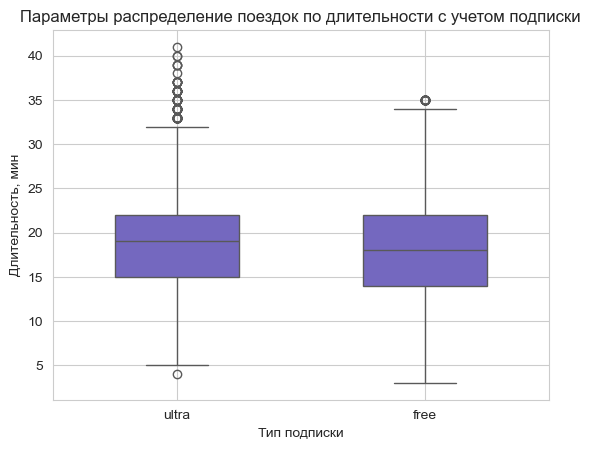

In [61]:
 # визуальный анализ параметров распределение по длительности с учетом подписки
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# строим график по всем поездкам
sns.boxplot(data=df, x='subscription_type', y='duration',
            width=0.5, color='#6A5ACD')

# настройки графика
ax.set_title("Параметры распределение поездок по длительности с учетом подписки")
ax.set_xlabel("Тип подписки")
ax.set_ylabel("Длительность, мин")

# включаем сетку
plt.grid(True)

plt.show()

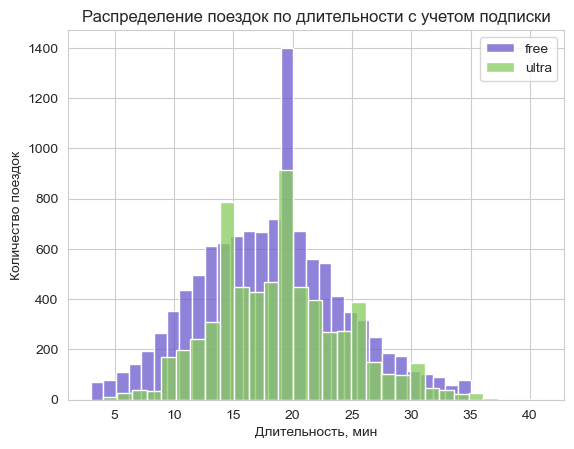

In [62]:
# выведем распределение длительности поездок с учетом типа подписки
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# строим график с free подпиской
sns.histplot(data=df[flag_free], x='duration', color='#6A5ACD',
             label='free', bins=30)
# строим график с ultra подпиской
sns.histplot(data=df[flag_ultra], x='duration', color='#87CC5C',
             label='ultra', bins=30)

# настройки графика
ax.set_title("Распределение поездок по длительности c учетом подписки")
ax.set_ylabel("Количество поездок")
ax.set_xlabel("Длительность, мин")

# включаем легенду
plt.legend()
# включаем сетку
plt.grid(True)

plt.show()

- [Сравнительная таблица параметров распределения по длительности поездки с учетом подписки](#param_dur)
- Основные пики по продолжительности поездок приходятся на 18–19 минут.
- Пользователи с подпиской ultra значительно чаще выбирают аренду длительностью около 14, 25 и 30 минут и реже продолжительностью до 8 минут ([с учетом общего распределения в соотношении 55/45%](#Соотношение-пользователей-с-платными-подписками-и-без)).

### Подсчёт выручки

Создадим DataFrame с данными о выручке, где для каждого пользователя будет указана информация с помесячной разбивкой.

In [63]:
# создаем dataframe с агрегированными данными 
"""
Поскольку данные о подписке для каждого пользователя
в каждом месяце одинаковы,можно применить любую 
агрегирующую функцию (min, max или mean) для обработки этих данных.
"""
df_revenue = df.pivot_table(index=['user_id', 'month'], 
               values=['distance',
                       'duration', 
                       'subscription_type',
                       'minute_price',
                       'start_ride_price',
                       'subscription_fee'],
               aggfunc={'distance':'sum', 
                       'duration':'sum',
                       'user_id':'count',
                       'subscription_type':'max',
                       'minute_price':'max',
                       'start_ride_price':'max',
                       'subscription_fee':'max'
                    }
                ).rename(columns={
                        'distance':'sum_distance',
                        'duration':'sum_duration',
                        'user_id':'cnt_rides'}).reset_index()

# проверка на пропуски
miss_count = df_revenue.isna().sum().sum() # суммарное кол-во попусков в df
if miss_count == 0:
    print('Пропусков не обнаружено')
else:
    print(f'Суммарное количество пропусков = {miss_count}')

# добавляем данные с расчетом выручки в месяц с пользователя
"""
Векторные операции (метод .eval) позволяют осуществлять 
операции над данными по строкам без указания dataframe
"""
df_revenue['month_revenue'] = df_revenue.eval("""
                        subscription_fee + \
                        minute_price * sum_duration + \
                        start_ride_price * cnt_rides \
                                            """)

df_revenue.head(5) # проверка

,user_id,month,sum_distance,sum_duration,minute_price,start_ride_price,subscription_fee,subscription_type,cnt_rides,month_revenue
0,1,1,7028,42,6,0,199,ultra,2,451
1,1,4,754,7,6,0,199,ultra,1,241
2,1,8,6724,46,6,0,199,ultra,2,475
3,1,10,5810,32,6,0,199,ultra,2,391
4,1,11,7004,56,6,0,199,ultra,3,535


#### Анализ помесячной выручки по пользователям

In [64]:
param = 'month_revenue' # указываем по какому параметру собираем данные
text_param = 'месячная выручка' # название параметра для вставки в текст

flag_u_r = (df_revenue.subscription_type=='ultra') # для выбора данных с платной подпиской
flag_f_r = (df_revenue.subscription_type=='free') # для выбора данных с бесплатной подпиской

# собираем данные с параметрами
data_temp = {
    'Параметр': [f'Средняя {text_param}:',
                f'Медианная {text_param}:',
                f'Количество значений'],
    'free': [(df_revenue[flag_f_r][param].mean()).round(2),
             df_revenue[flag_f_r][param].median(),
            len(df_revenue[flag_f_r][param])],
    'ultra': [(df_revenue[flag_u_r][param].mean()).round(2),
             df_revenue[flag_u_r][param].median(),
            len(df_revenue[flag_u_r][param])]
                }

df_par_dist = pd.DataFrame(data_temp) # создаем dataframe

df_par_dist # выводим результат

,Параметр,free,ultra
0,Средняя месячная выручка:,328.97,362.79
1,Медианная месячная выручка:,274.00,337.00
2,Количество значений,6747.00,4533.00


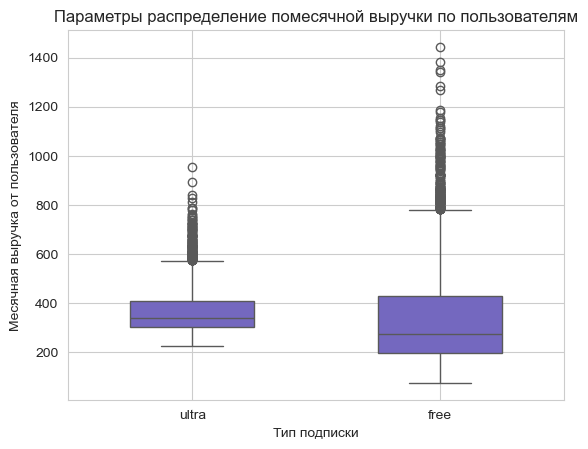

In [65]:
# визуальный анализ параметров распределение по
# месячной выручки с учетом подписки
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# строим график по всем поездкам
sns.boxplot(data=df_revenue, x='subscription_type', y='month_revenue',
            width=0.5, color='#6A5ACD')

# настройки графика
ax.set_title("Параметры распределение помесячной выручки по пользователям")
ax.set_xlabel("Тип подписки")
ax.set_ylabel("Месячная выручка от пользователя")

# включаем сетку
plt.grid(True)

plt.show()

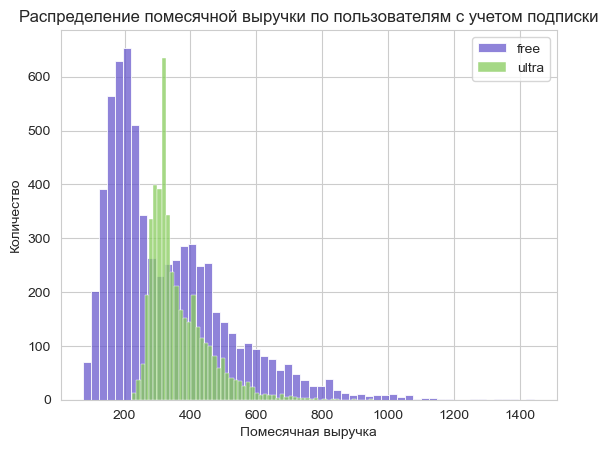

In [66]:
# выведем распределение помесячной выручки с учетом типа подписки
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# строим график с free подпиской
sns.histplot(data=df_revenue[flag_f_r], x='month_revenue', color='#6A5ACD',
             label='free')
# строим график с ultra подпиской
sns.histplot(data=df_revenue[flag_u_r], x='month_revenue', color='#87CC5C',
             label='ultra')

# настройки графика
ax.set_title("Распределение помесячной выручки по пользователям c учетом подписки")
ax.set_ylabel("Количество")
ax.set_xlabel("Помесячная выручка")

# включаем легенду
plt.legend()
# включаем сетку
plt.grid(True)

plt.show()

- Средняя помесячная выручка у пользователей с подпиской Ultra немного выше, чем у пользователей без подписки.
- Основной пик помесячной выручки для пользователей с подпиской Ultra находится около 350 рублей, в то время как у пользователей без подписки он составляет примерно 200 рублей.

### Проверка гипотез

In [67]:
# функция генерации средних по выборкам
def gen_m_select(data, size:int, cnt:int):
    """
    Генерируем выборки и вычисляем их средние
    
    :data: генеральная совокупность
    :size: размер выборки (тип int)
    :cnt: количество выборок (тип int)
    :return: список со средними значениями выборок
    """
    sample_means = list() # список средних по случайным выборкам
    for n in range(cnt):
        sample = np.random.choice(data, size=size, replace=True) # случайную выборку
        sample_means.append(np.mean(sample)) # записываем среднее по выборке
    return sample_means

#### Гипотеза №1

**Цель:** Проверить тратят ли пользователи с подпиской больше времени на поездки.
<br><br>
**Гипотеза:** <br>
Нулевая гипотеза H<sub>0</sub> - среднее время поездок пользователей с подпиской меньше или равно среднему времени поездок пользователей без подписки μ<sub>ultra</sub><=μ<sub>free</sub>. <br>
Альтернативная гипотеза H<sub>1</sub> - среднее время поездок пользователей с подпиской больше, чем у пользователей без подписки μ<sub>ultra</sub>>μ<sub>free</sub>.

[Ранее](#Распределение-длительности-поездки-с-учетом-подписки) был произведен анализ распределения и получены основные параметры распределения. Согласно полученным данным, пользователи с подпиской тратят больше времени на поездки, при этом распределение является равномерным. <br>
Проверим гипотезу с использованием статистических методов.<br><br>

Для корректности результатов проведем два статистических теста:
1) т-тест (зависит от равномерного распределения)
2) тест Манна-Уитни (не зависит от равномерного распределения)

In [68]:
# проверка дисперсий генеральных совокупностей
var_month_rev_u = df[flag_ultra]['duration'].var() # дисперсия для ultra
var_month_rev_f = df[flag_free]['duration'].var() # дисперсия для free

print(f'Дисперсия duration ultra: {var_month_rev_u}')
print(f'Дисперсия duration free: {var_month_rev_f}')
print(f'delta: {var_month_rev_u - var_month_rev_f}')

Дисперсия duration ultra: 31.10782664788694
Дисперсия duration free: 37.55354042918671
delta: -6.445713781299769


Дисперсии двух генеральных совокупностей не равны (разница стандартном отклонении около 0,5 минуты)

In [69]:
# односторонний т-тест (альтернатива 'больше') 

# данные (формируем в ячейки, чтобы обеспечить независимость выполнения)
data_1 = df[flag_ultra]['duration']  # время поездок пользователей ultra
data_2 = df[flag_free]['duration']  # время поездок пользователей free

# проведение одностороннего т-теста (альтернатива "больше")
results = st.ttest_ind(data_1, data_2,
                               equal_var=False, # дисперсии не равны, выборки большие 
                               alternative='greater')

print(f"p-value (т-тест): {results.pvalue}")

p-value (т-тест): 7.044474516954838e-26


In [70]:
# односторонний тест Манна-Уитни (альтернатива 'больше') 

# данные (формируем в ячейки, чтобы обеспечить независимость выполнения)
data_1 = df[flag_ultra]['duration']  # время поездок пользователей ultra
data_2 = df[flag_free]['duration']  # время поездок пользователей free

# проведение одностороннего теста Манна-Уитни (альтернатива "больше")
results = st.mannwhitneyu(data_1, 
                               data_2,
                               alternative='greater')

print(f"p-value (тест Манна-Уитни): {results.pvalue}")

p-value (тест Манна-Уитни): 1.7249077327775086e-21


Уровень статистической значимости принимаем за 0.05. <br>
Оба теста показали очень низкое значение p-value (е-26 и е-21). <br>
**Отвергаем нулевую гипотезу. <br>
Не отвергаем альтернативную гипотезу: среднее время поездок пользователей с подпиской больше среднему времени поездок пользователей без подписки**

##### Дополнительная проверка случайной выборкой

Односторонний т-тест (альтернатива "больше")
p-value (т-тест): 3.024950518434813e-127


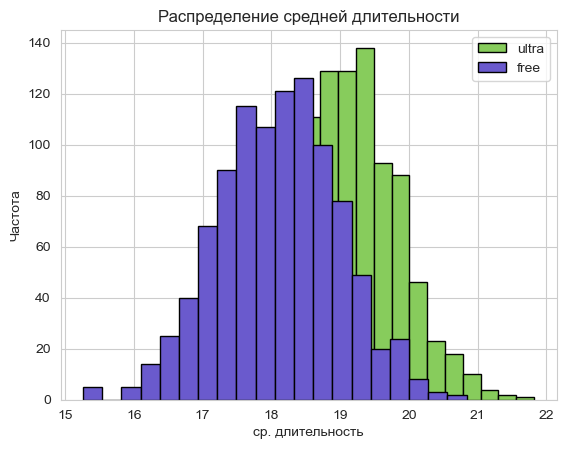

In [71]:
# сравниваем средние значения по выборкам из 50 элементов (1000 выборок)
data_1 = gen_m_select(df[flag_ultra]['duration'], 50, 1000)
data_2 = gen_m_select(df[flag_free]['duration'], 50, 1000)

print('Односторонний т-тест (альтернатива "больше")')
results = st.ttest_ind(data_1, data_2,
                       equal_var=False,
                            alternative='greater')
print(f"p-value (т-тест): {results.pvalue}")

# гистограмма средних значений
plt.hist(data_1, bins=20, color='#87CC5C', edgecolor='black', label='ultra')
plt.hist(data_2, bins=20, color='#6A5ACD', edgecolor='black', label='free')
plt.title("Распределение средней длительности")
plt.xlabel("ср. длительность")
plt.ylabel("Частота")
plt.legend() # включаем легенду
plt.show()

mean p-value: 0.040067850865709465


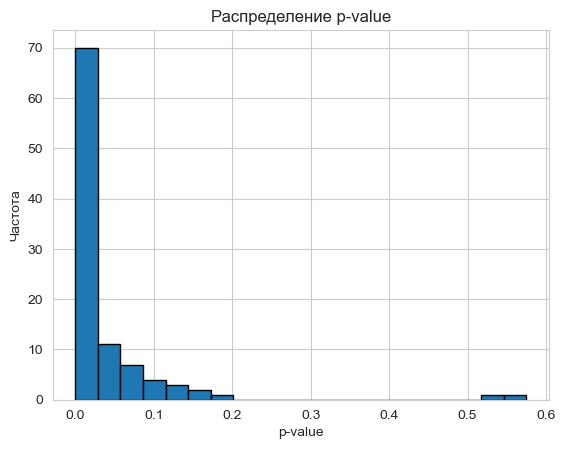

In [72]:
# проверка распределения p-value через бутстреп подход
pvalues_list = list()
for n in range(100): 
    # генерация случайных выборок 
    data_1 = np.random.choice(df[flag_ultra]['duration'], size=500, replace=True)
    data_2 = np.random.choice(df[flag_free]['duration'], size=500, replace=True) 
    
    # проведение одностороннего т-теста (альтернатива "больше")
    results = st.ttest_ind(data_1, data_2,
                           equal_var=False,
                                   alternative='greater')
    pvalues_list.append(results.pvalue)

# усредненная p-value
print(f'mean p-value: {np.mean(pvalues_list)}')

# гистограмма p-value
plt.hist(pvalues_list, bins=20, edgecolor='black')
plt.title("Распределение p-value")
plt.xlabel("p-value")
plt.ylabel("Частота")
plt.show()

Гистограмма распределения средних значений показывает преобладание длительности у пользователей с подпиской. <br>
Результаты t-теста показывают что значение p-value стремится к нулю <br>
Значит можем отвергнуть нулевую гипотезу, что среднее время пользователей с подпиской меньше или равно среднему времени пользователей без подписки.

#### Гипотеза №2

**Цель:** Проверить что среднее расстояние, которое проезжают пользователи с подпиской не превышает 3130 метров.

**Гипотеза:** <br>
Нулевая гипотеза H<sub>0</sub> - среднее дальность поездок пользователей с подпиской меньше или равно 3130 метров μ<sub>ultra</sub><=3130. <br>
Альтернативная гипотеза H<sub>1</sub> - среднее дальность поездок пользователей с подпиской больше 3130 метров μ<sub>ultra</sub>>3130.


[Ранее](#Распределение-дальности-поездки-с-учетом-подписки) был произведен анализ распределения и получены основные параметры распределения. Согласно полученным данным, пользователи с подпиской в среднем проезжают около 3000 метров, при этом распределение является равномерным с "хвостом" в районе 1000 метров. <br>
Проверим гипотезу с использованием статистических методов.

In [73]:
# односторонний одновыборочный т-тест (альтернатива 'больше') 

alpha = 0.05 # задаем уровень статистической значимости

# данные (формируем в ячейки, чтобы обеспечить независимость выполнения)
data_1 = df[flag_ultra]['distance']  # время поездок пользователей ultra
interested_value = 3130 # 'оптимальное' среднее значение

# проведение т-теста (альтернатива "больше")
results = st.ttest_1samp(data_1, interested_value,
                               alternative='greater')

print(f"p-value (т-тест): {results.pvalue}")

if results.pvalue < alpha: # сравните p-значение с заданным уровнем значимости alpha
    print("""Отвергаем нулевую гипотезу
что средняя дальность поездки пользователей
с подпиской, меньше или равно 3130 метров""")
else:
    print("""Не получилось отвергнуть нулевую гипотезу 
что средняя дальность поездки пользователей
с подпиской, меньше или равно 3130 метров""")

p-value (т-тест): 0.9195649894697725
Не получилось отвергнуть нулевую гипотезу 
что средняя дальность поездки пользователей
с подпиской, меньше или равно 3130 метров


По результатам t-теста не удалось отвергнуть нулевую гипотезу о том, что средняя дальность поездки пользователей с подпиской меньше или равна 3130 метрам. Это может указывать на то, что средняя дальность поездки превышает 3130 метров. <br>

**Не отвергаем нулевую гипотезу: средняя дальность поездки пользователей с подпиской меньше или равна 3130 метрам.**

##### Дополнительная проверка  случайной выборкой

Односторонний одновыборочный т-тест (альтернатива "больше")
p-value (т-тест): 0.9999957665259855


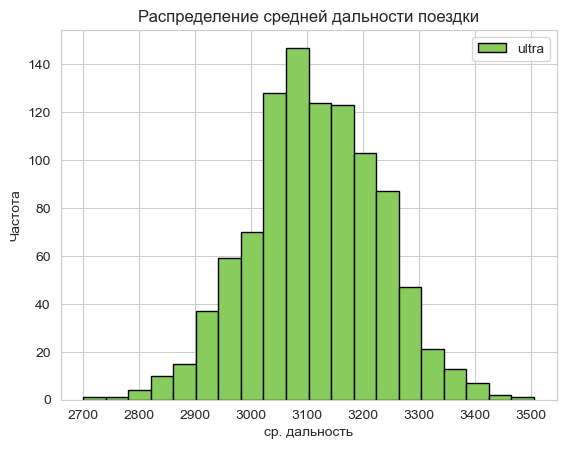

In [74]:
# сравниваем средние значения по выборкам из 50 элементов (1000 выборок)
data_1 = gen_m_select(df[flag_ultra]['distance'], 50, 1000)
interested_value = 3130 # 'оптимальное' среднее значение

print('Односторонний одновыборочный т-тест (альтернатива "больше")')
results = st.ttest_1samp(data_1, interested_value,
                            alternative='greater')
print(f"p-value (т-тест): {results.pvalue}")

# гистограмма средних значений
plt.hist(data_1, bins=20, color='#87CC5C', edgecolor='black', label='ultra')
plt.title("Распределение средней дальности поездки")
plt.xlabel("ср. дальность")
plt.ylabel("Частота")
plt.legend() # включаем легенду
plt.show()

mean p-value: 0.5676678142942176


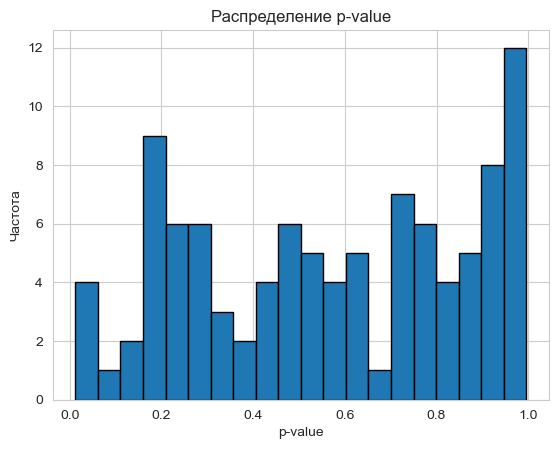

In [75]:
# проверка распределения p-value через бутстреп подход
interested_value = 3130 # 'оптимальное' среднее значение
pvalues_list = list()

for n in range(100): 
    # генерация случайных выборок 
    data_1 = np.random.choice(df[flag_ultra]['distance'], size=500, replace=True)
    
    # проведение одностороннего т-теста (альтернатива "больше")
    results = st.ttest_1samp(data_1, interested_value,
                                   alternative='greater')
    pvalues_list.append(results.pvalue)

# усредненная p-value
print(f'mean p-value: {np.mean(pvalues_list)}')

# гистограмма p-value
plt.hist(pvalues_list, bins=20, edgecolor='black')
plt.title("Распределение p-value")
plt.xlabel("p-value")
plt.ylabel("Частота")
plt.show()

Пик средних значений дальности поездок для пользователей с подпиской, рассчитанных по случайным выборкам, находится в диапазоне 3000–3200 метров. При этом p-value для средних значений близко к 1.0. <br>
Распределение p-value, полученное по 100 случайным выборкам (по 500 элементов в каждой), близко к равномерному, а его среднее значение лежит в диапазоне 0.5–0.65.<br>
Эти наблюдения не позволяют отвергнуть нулевую гипотезу.

#### Гипотеза №3

**Цель:** Проверить что месячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки. <br>

**Гипотеза:** <br>
Нулевая гипотеза H<sub>0</sub> - месячная выручка от пользователей с подпиской меньше или ровна месячной выручки пользователя без подписки μ<sub>ultra</sub><=μ<sub>free</sub>. <br>
Альтернативная гипотеза H<sub>1</sub> - месячная выручка от пользователей с подпиской больше, чем от средняя выручка от пользователей без подписки μ<sub>ultra</sub>>μ<sub>free</sub>.

[Ранее](#Анализ-помесячной-выручки-по-пользователям) был произведен анализ распределения и получены основные параметры распределения. Согласно полученным данным, пользователи с подпиской в среднем приносят больше прибыли, чем пользователи без подписки. Распределения имеет равномерный характер с выраженным скосом влево. <br>
Т.к. есть скос влево проведем анализ дисперсий генеральных совокупностей

In [76]:
# проверка дисперсий генеральных совокупностей
var_month_rev_u = df_revenue[flag_u_r]['month_revenue'].var() # дисперсия для ultra
var_month_rev_f = df_revenue[flag_f_r]['month_revenue'].var() # дисперсия для free

print(f'Дисперсия month_revenue ultra: {var_month_rev_u}')
print(f'Дисперсия month_revenue free: {var_month_rev_f}')
print(f'delta: {var_month_rev_u - var_month_rev_f}')

Дисперсия month_revenue ultra: 7790.310733351123
Дисперсия month_revenue free: 33404.647297075935
delta: -25614.336563724813


Дисперсии сильно отличаются

Для корректности результатов проведем два статистических теста:
1) т-тест (зависит от равномерного распределения)
2) тест Манна-Уитни (не зависит от равномерного распределения)

In [77]:
# односторонний т-тест (альтернатива 'больше') 

# данные (формируем в ячейки, чтобы обеспечить независимость выполнения)
data_1 = df_revenue[flag_u_r]['month_revenue']  # время поездок пользователей ultra
data_2 = df_revenue[flag_f_r]['month_revenue']  # время поездок пользователей free

# проведение одностороннего т-теста (альтернатива "больше")
results = st.ttest_ind(data_1, data_2,
                               equal_var=False, # дисперсии не равны
                               alternative='greater')

print(f"p-value (т-тест): {results.pvalue}")

p-value (т-тест): 3.5911713410539164e-39


In [78]:
# односторонний тест Манна-Уитни (альтернатива 'больше') 

# данные (формируем в ячейки, чтобы обеспечить независимость выполнения)
data_1 = df_revenue[flag_u_r]['month_revenue']  # время поездок пользователей ultra
data_2 = df_revenue[flag_f_r]['month_revenue']  # время поездок пользователей free

# проведение одностороннего теста Манна-Уитни (альтернатива "больше")
results = st.mannwhitneyu(data_1, data_2,
                               alternative='greater')

print(f"p-value (тест Манна-Уитни): {results.pvalue}")

p-value (тест Манна-Уитни): 8.352289216119809e-133


Уровень статистической значимости принимаем за 0.05. <br>
Оба теста показали очень низкое значение p-value (е-39 и е-133). <br>
**Отвергаем нулевую гипотезу. <br>
Не отвергаем альтернативную гипотезу: месячная выручка от пользователей с подпиской больше, чем средняя выручка от пользователей без подписки**

##### Дополнительная проверка случайной выборкой

Односторонний т-тест (альтернатива "больше")
p-value (т-тест): 4.739300721463047e-205


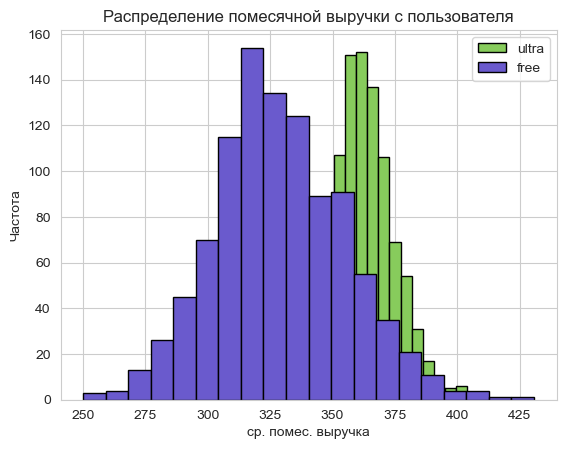

In [79]:
# сравниваем средние значения по выборкам из 50 элементов (1000 выборок)
data_1 = gen_m_select(df_revenue[flag_u_r]['month_revenue'], 50, 1000)
data_2 = gen_m_select(df_revenue[flag_f_r]['month_revenue'], 50, 1000)

print('Односторонний т-тест (альтернатива "больше")')
results = st.ttest_ind(data_1, data_2,
                       equal_var=False,
                            alternative='greater')
print(f"p-value (т-тест): {results.pvalue}")

# гистограмма средних значений
plt.hist(data_1, bins=20, color='#87CC5C', edgecolor='black', label='ultra')
plt.hist(data_2, bins=20, color='#6A5ACD', edgecolor='black', label='free')
plt.title("Распределение помесячной выручки с пользователя")
plt.xlabel("ср. помес. выручка")
plt.ylabel("Частота")
plt.legend() # включаем легенду
plt.show()

mean p-value: 0.004214721011147275


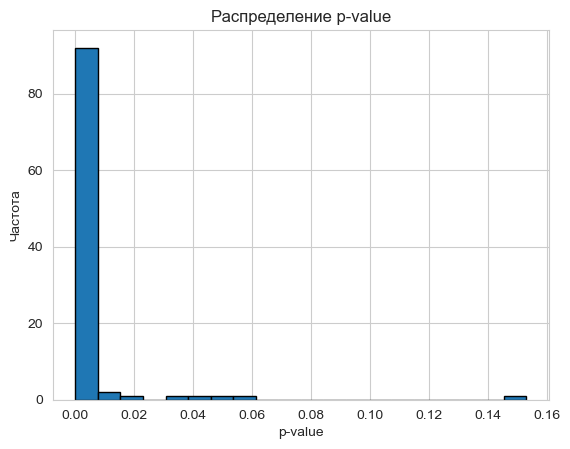

In [80]:
# проверка распределения p-value через бутстреп подход
pvalues_list = list()
for n in range(100): 
    # генерация случайных выборок 
    data_1 = np.random.choice(df_revenue[flag_u_r]['month_revenue'], size=500, replace=True)
    data_2 = np.random.choice(df_revenue[flag_f_r]['month_revenue'], size=500, replace=True) 
    
    # проведение одностороннего т-теста (альтернатива "больше")
    results = st.ttest_ind(data_1, data_2,
                           equal_var=False,
                                   alternative='greater')
    pvalues_list.append(results.pvalue)

# усредненная p-value
print(f'mean p-value: {np.mean(pvalues_list)}')

# гистограмма p-value
plt.hist(pvalues_list, bins=20, edgecolor='black')
plt.title("Распределение p-value")
plt.xlabel("p-value")
plt.ylabel("Частота")
plt.show()

Гистограмма распределения средних значений показывает увеличение выручки от пользователей с подпиской. <br>
Результаты t-теста показывают что значение p-value стремится к нулю <br>
Значит можем отвергнуть нулевую гипотезу, что помесячная выручка от пользователей с подпиской меньше или равно помесячной выручки от пользователей без подписки.

#### Гипотеза №4 (теоретическая)

**Легенда:** техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него.

**Цель:** Проверить снижение обращений в техподдержку после обновления приложения. <br>

**Гипотеза:** <br>
Нулевая гипотеза H<sub>0</sub> - количество обращений в техподдержку после обновления приложения увеличилось или осталось неизменным μ<sub>new</sub>>=μ<sub>past</sub>. <br>
Альтернативная гипотеза H<sub>1</sub> - количество обращений в техподдержку после обновления приложения уменьшилось μ<sub>new</sub><μ<sub>past</sub>.

Для статистической проверки можно использовать метод **stats.ttest_rel** из библиотеки **scipy** с параметром **alternative='less'**, сравнивая две выборки: количество обращений до обновления приложения и количество обращений после обновления.

#### Выводы по проверке гипотез

1) Проверить тратят ли пользователи с подпиской больше времени на поездки. <br>
**Не отвергаем гипотезу, что среднее время поездок пользователей с подпиской больше среднему времени поездок пользователей без подписки** <br> <br>
2) Проверить что среднее расстояние, которое проезжают пользователи с подпиской не превышает 3130 метров.<br>
**Не отвергаем гипотезу, что средняя дальность поездки пользователей с подпиской меньше или равна 3130 метрам.** <br> <br>
3) Проверить что месячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки. <br>
**Не отвергаем гипотезу, что месячная выручка от пользователей с подпиской больше, чем средняя выручка от пользователей без подписки** <br> <br>
4) (Теоретическая) Проверить снижение обращений в техподдержку после обновления приложения. <br>
Для статистической проверки можно использовать метод stats.ttest_rel из библиотеки scipy с параметром alternative='less', сравнивая две выборки: количество обращений до обновления приложения и количество обращений после обновления.

### Анализ маркетинговых задач

#### Задача №1: определение минимального количенства промокодов

**Задача:** Определить минимальное количество промокодов, которые нужно разослать пользователям без подписки, чтобы с вероятностью в 95% 100 пользователей продлили подписку. В среднем подписку продлевают 10% пользователей получивших бесплатный промокод на месяц.

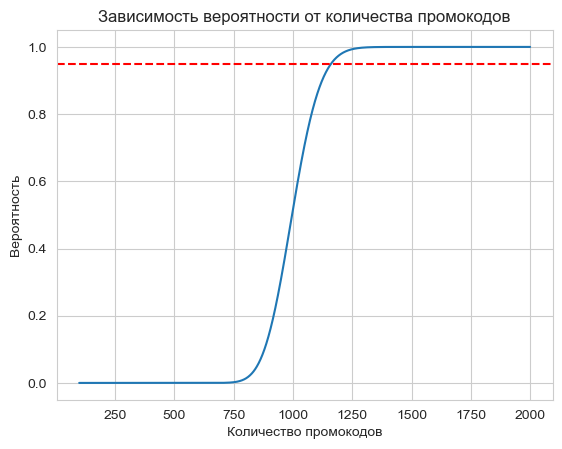

In [81]:
# определяем минимальное количество промокодов

p = 0.1 # вероятность продления (успеха)
value = 100 # целевое значение
lvl_confidence = 0.95 # уровень необходимой уверености

n_values = range(value, 2000) # подбираем диапазон значений

# вычисляем вероятности для каждого значения
probability = [1-st.binom.cdf(value-1, x, p) for x in n_values] # 100 включительно

# cтроим график вероятностей 
plt.plot(n_values, probability)
plt.axhline(lvl_confidence, color="red", linestyle="--") # пунктиром нужное значение
plt.title("Зависимость вероятности от количества промокодов")
plt.xlabel("Количество промокодов")
plt.ylabel("Вероятность")
plt.show()

По графику определяем примерный диапазон от 1100 до 1200. Посмтроим график в этом диапазоне значений.

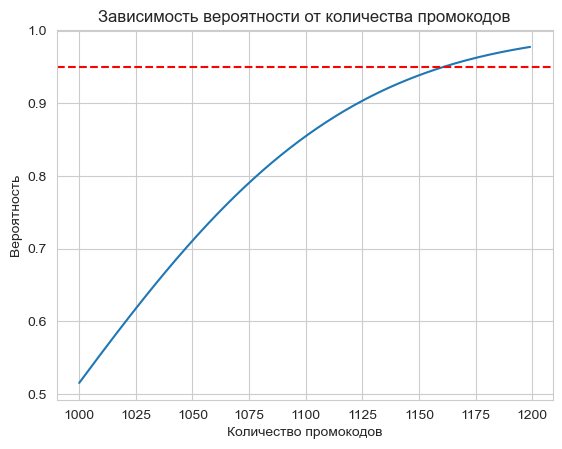

In [82]:
# cтроим график вероятностей в диапазоне 1100-1200
n_values = range(1000, 1200) 

# вычисляем вероятности для каждого значения в новом диапазоне
# срез лучше не делать т.к. есть смещение по минимальному значению
probability = [1-st.binom.cdf(value-1, x, p) for x in n_values] # 100 включительно

plt.plot(n_values, probability)
plt.axhline(lvl_confidence, color="red", linestyle="--") # пунктиром нужное значение
plt.title("Зависимость вероятности от количества промокодов")
plt.xlabel("Количество промокодов")
plt.ylabel("Вероятность")
plt.show()

Можем снизить диапазон значений до 1150-1175 и найти значение с вероятностью 95 или выше.

In [83]:
# находим минимальное значение с нужной вероятностью

p = 0.1 # вероятность продления (успеха)
value = 100 # целевое значение
lvl_confidence = 0.95 # уровень необходимой уверености

n_values = range(1150, 1175) # диапазон значений

# вычисляем вероятности для каждого значения в новом диапазоне
# срез лучше не делать т.к. есть смещение по минимальному значению
probability = [1-st.binom.cdf(value-1, x, p) for x in n_values] # 100 включительно

min_n = 0 # определяем минимальное значение

# находим минимальное n для заданного уровня уверенности
for n, p_n in zip(n_values, probability): # перебираем значения
    if p_n >= lvl_confidence: # сверяем на соответствие условию уровня уверенности
        min_n = n
        break # в случае нахождения останавливаем цикл

if min_n != 0:
    print('n=',n)
else:
    # для бесконечного биноминального распределения
    # всегда есть нужное число эксперементов
    print('Диапазон определен не верно') 

n= 1161


In [85]:
# выполним проверку обратной функцией ppf

p = 0.1 # вероятность продления (успеха)
value = 100 # целевое значение
lvl_confidence = 0.95 # уровень необходимой уверености
n = 1161 # найденное значение n

# получаем значения с заданной вероятностью и заданным распределением 
value_n = st.binom.ppf(1 - lvl_confidence, n, p) # значение при n
value_n_0 = st.binom.ppf(1 - lvl_confidence, n-1, p) # значение при n-1

print(f"При n={n} значение={value_n}")
print(f"При n-1={n-1} значение={value_n_0}")

if value_n >= value:
    print("Условие выполнено, минимальное значение найденно")
else:
    print("Условие не выполнено, была допущена ошибка")

При n=1161 значение=100.0
При n-1=1160 значение=99.0
Условие выполнено, минимальное значение найденно


Этапы выполнения можно сократить работая с большим диапазоном без визуального определения диапазона.

**Ответ:** Чтобы с вероятностью 95% как минимум 100 пользователей продлили подписку, необходимо раздать **не менее 1161 промокодов**.

#### Задача №2: определение эффективности push-уведомлений

**Задача:** Определить вероятность того, что уведомление откроют не более 399,5 тыс пользователей, при условии, что будет разослано 1 млн уведомлений и около 40% пользователей открывают их.

Для более быстрого решения применим нормальную аппроксимацию биномиального распределения.

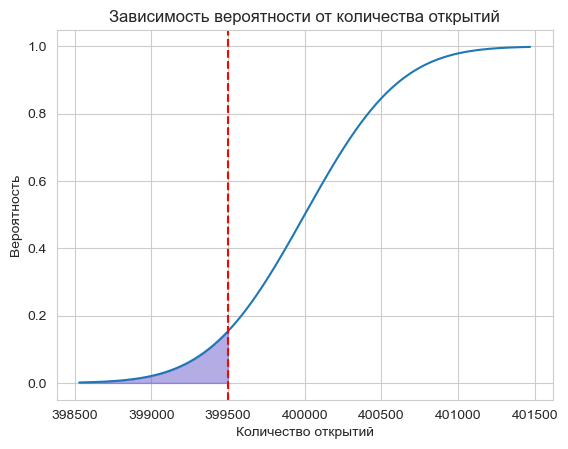

In [86]:
# с помощью аппроксимации построим примерный график
# распределения и определим вероятность условия

# вводные параметры
n = 10**6 # кол-во уведомлений (экспериментов)
p = 0.4 # вероятность открытия (успеха)
value = 399500 # кол-во успехов

# параметры нормального распределения
mu = n*p # среднее значение распределения
sigma = np.sqrt(n*p*(1-p)) # стандартное отклонение

distr = st.norm(mu, sigma) # объект нормального распреределения

result = distr.cdf(value) # вероятность открытия "менее"

# строим график распределения

# определяем диапазон значений успехов
x_values = np.arange((mu-3*sigma), (mu+3*sigma)) # исп. правило трех сигм

plt.plot(x_values, distr.cdf(x_values)) # x-кол-во успехов, y-вероятность
plt.axvline(value, color="red", linestyle="--") # пунктиром нужное значение
plt.fill_between(x_values, distr.cdf(x_values),
                 where=(x_values <= value), 
                 color="#6A5ACD", alpha=0.5) # закрашиваем нужный диапазон
plt.title("Зависимость вероятности от количества открытий")
plt.xlabel("Количество открытий")
plt.ylabel("Вероятность")
plt.show()

In [87]:
# выводим результат по вероятности открытия 
print(f"""Вероятность открытия не более 399,5 тыс
      push уведомлений составляет {result*100:.2f} %""")

Вероятность открытия не более 399,5 тыс
      push уведомлений составляет 15.37 %


**Ответ:** При текущих условиях вероятность того, что будет **открыто не более 399,5 тыс** push-уведомлений, составляет **15,37%**.

### Общий вывод

**Предобработка данных:** <br>
- Данные предоставлены за весь 2021 год
- Перевели поле date в формат date
- Перевели поле distance в формат int c математическим округлением
- Перевели поле duration в формат int c округлением в большую сторону
- Добавили в df rides поле month с указанием номера месяца поездки
- Добавили в df rides поле avg_speed с указанием средней скорости поездки
- Определили что производится аренда обычных самокатов
- [Выполнили проверку на мошенничество аномальных поездок](#Проверка-на-мошенничество-аномальных-значений)
- Из df rides удалили 95 строк со временем поездки 1 мин, 77 строк с дальностью поездки менее 100 м
- Выявили невозможность по текущим данным проверить дату/месяц поездки
- Из df users удалили 31 строку с дубликатами пользователей

**Исследовательский анализ данных:**
- Распределение пользователей по городам является достаточно равномерным: максимальная разница между городами составляет не более 3%.
- Среднее соотношение между пользователями с платной подпиской и без нее составляет 45,6%. 
- Распределение пользователей с подпиской по городам достаточно равномерное, однако в Москве и Омске наблюдается небольшое превышение доли таких пользователей — по 50%.
- Средний возраст пользователя: 24.9 лет. Общее распределение по возрасту: нормальное с вершиной в 25 лет. 
- Доля платной подписки распределена относительно равномерно среди всех возрастных групп, составляя от 42% до 52%
- Средняя дальность поездки: 3072.78 м.  Общее распределение поездок по дальности: нормальное с вершиной в 3200 метров. Наблюдается небольшой рост числа поездок на расстояние около 700 метров. 
- Средняя длительность поездки: 18.44 мин. Общее распределение поездок по дальности: нормальное с вершиной в 18 минут. 
- Диапазон дальности поездок у пользователей с подпиской ultra более сконцентрирован по сравнению с пользователями без подписки. Основной пик дальности для пользователей с подпиской ultra находится на отметке 3000 метров, тогда как у пользователей без подписки он распределен в диапазоне от 2200 до 4000 метров. Для коротких поездок пик у пользователей с подпиской ultra наблюдается около 1000 метров, а у пользователей без подписки — около 500 метров.
- Основные пики по продолжительности поездок приходятся на 18–19 минут. Пользователи с подпиской ultra значительно чаще выбирают аренду длительностью около 14, 25 и 30 минут и реже продолжительностью до 8 минут 


**Проверка гипотез:**
1) **[Гипотеза №1](#Гипотеза-№1):** <br>
   &nbsp;&nbsp;&nbsp;&nbsp; Необходимо проверить тратят ли пользователи с подпиской больше времени на поездки. <br><br> 
**Результат проверки:** среднее время поездок пользователей с подпиской больше среднего времени поездок пользователей без подписки. <br><br><br> 

2) **[Гипотеза №2](#Гипотеза-№2):** <br>
   &nbsp;&nbsp;&nbsp;&nbsp; Необходимо проверить что среднее расстояние, которое проезжают пользователи с подпиской, не превышает 3130 метров. <br><br> 
**Результат проверки:** средняя дальность поездки пользователей с подпиской меньше или равна 3130 метрам. <br><br><br>

3) **[Гипотеза №3](#Гипотеза-№3):** <br>
   &nbsp;&nbsp;&nbsp;&nbsp; Необходимо проверить, что месячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки. <br><br>
**Результат проверки:** месячная выручка от пользователей с подпиской больше, чем средняя выручка от пользователей без подписки. <br><br><br>

4) **[Гипотеза №4 (теоретическая)](#Гипотеза-№4-(теоретическая)):** <br>
   &nbsp;&nbsp;&nbsp;&nbsp; Необходимо проверить что уменьшилось число обращений в техподдержку после обновления приложения. <br><br>
**Описание теоретического решения:** Для статистической проверки можно использовать метод stats.ttest_rel из библиотеки scipy с параметром alternative='less', сравнивая две выборки: количество обращений до обновления приложения и количество обращений после обновления.

**Анализ маркетинговых задач:**
1) **[Задача №1](#Задача-№1:-определение-минимального-количенства-промокодов):** Определить минимальное количество промокодов, которые нужно разослать пользователям без подписки, чтобы с вероятностью в 95% 100 пользователей продлили подписку. В среднем подписку продлевают 10% пользователей получивших бесплатный промокод на месяц. <br><br>
**Ответ:** Чтобы с вероятностью 95% как минимум 100 пользователей продлили подписку, необходимо раздать не менее 1161 промокодов.<br><br><br>

2) **[Задача №2](#Задача-№2:-определение-эффективности-push-уведомлений):** Определить вероятность того, что уведомление откроют не более 399,5 тыс пользователей, при условии, что будет разослано 1 млн уведомлений и около 40% пользователей открывают их. <br><br>
**Ответ:** При текущих условиях вероятность того, что будет открыто не более 399,5 тыс push-уведомлений, составляет 15,37%.

**Для увеличения качества анализа требуется дополнительные данные:**

* Типы арендуемых самокатов
* Место аренды самоката
* Сезонность аренды по городам
* Время начала и завершения аренды
* Даты начала и окончания подписок
* Информация об обращениях в техническую поддержку сервиса
* Информация о возможных мероприятиях (например, аренда в закрытых помещениях, маркетинговые мероприятия и прочее)
* Методология сбора данных о пользователях
* Регламент оплаты подписок (минимальные сроки, условия)
* Учет времени вне сезона аренды